<a href="https://www.kaggle.com/code/amirbaniasadi/price-prediction-by-different-sklearn-techniques?scriptVersionId=143021788" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In this Notebook, EDA is done and after data cleaning and modification in regard with omitting outliers and also focusing on special part of data, modeling techniques are compared in term of R-square for train and test sets.

# Importing Libraries

In [ ]:
# importing required libraries
import numpy as np 
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

import plotly.express as px

from bs4 import BeautifulSoup as BS
import requests

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.linear_model import  ElasticNet, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor

import time

In [ ]:
# import warnings
# warnings.filterwarnings('ignore')

In [ ]:
data = pd.read_csv('/kaggle/input/housesalesprediction/kc_house_data.csv')

# EDA and data modification

In [ ]:
data.head()

**omitting the extra and meaningless part of the date column**

In [ ]:
data['date'] = data.apply(lambda x: x.date[0:8], axis=1)

**Creating an "age" column based on date of selling and date of built**

In [ ]:
data['age'] = data.apply(lambda x: int(x.date[0:4]) - x.yr_built, axis=1)

**Creating an "age_renovated" column based on date of selling and date of renovation**

In [ ]:
data['age_renovated'] = data.apply(lambda row: row.age if row.yr_renovated == 0 else int(row.date[0:4]) - row.yr_renovated, axis = 1)

In [ ]:
data.head()

In [ ]:
data.columns

In [ ]:
data = data[['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'age', 'yr_renovated',  'age_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15']]

In [ ]:
data.sample(5)

In [ ]:
data.columns

In [ ]:
df = data.copy()

In [ ]:
df.isnull().sum()

In [ ]:
df.info()

In [ ]:
df.describe()

**Creating a new column which includes the price of each square meter of the property**

In [ ]:
df['persqft']= df['price'] / df['sqft_living']

In [ ]:
df['persqft']

In [ ]:
df.shape

In [ ]:
print(df.dtypes)

In [ ]:
df = df[['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'persqft', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'age', 'yr_renovated',
       'age_renovated', 'zipcode', 'lat', 'long', 'sqft_living15',
       'sqft_lot15']]

In [ ]:
df.head()

**requesting the data for zip codes and their related city from a website**

In [ ]:
url = "https://www.ciclt.net/sn/clt/capitolimpact/gw_ziplist.aspx?FIPS=53033"
data = requests.get(url)
soup = BS(data.text,'html.parser')

**scraping the website and saving the zipcode and city pairs in a dictionary**

In [ ]:
ZipCode_dict = {}
for i in soup.find_all(border = '3'):

    for j in i.find_all('tr'):
        k = j.find(align='left')
        if k!= None:
            zip = int(k.get_text())
            city = k.next_sibling.next_sibling.get_text()
            ZipCode_dict[zip]=city

**creating a new column based on the zipcode column and the dictionary**

In [ ]:
df['city'] = df["zipcode"].map(ZipCode_dict)

In [ ]:
df.isnull().sum()

In [ ]:
df.columns

In [ ]:
df = df[['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'persqft', 'floors', 'waterfront', 'view', 'condition',
       'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'age',
       'yr_renovated', 'age_renovated', 'zipcode', 'city', 'lat', 'long',
       'sqft_living15', 'sqft_lot15']]

In [ ]:
df.bedrooms.unique()

In [ ]:
#what percent of the properties have waterfront
df['waterfront'].value_counts(normalize=True)*100

**table for grade versus waterfront**

In [ ]:
pd.crosstab(df.waterfront, df.grade )

In [ ]:
df.columns

**plotting price versus some of other independent variables**

In [ ]:
sns.pairplot(data=df,
             x_vars = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'waterfront', 'view', 'condition', 'grade'],
             y_vars=['price'])
plt.show()

In [ ]:
sns.pairplot(data=df,
             x_vars = ['sqft_above', 'sqft_basement', 'yr_built', 'age', 'age_renovated', 'lat', 'long', 'sqft_living15', 'sqft_lot15'],
             y_vars=['price'])
plt.show()

In [ ]:
below_900 = df[ df.sqft_living <= 900 ]
len(below_900)

In [ ]:
df[ df.sqft_living <= 1000 ]["waterfront"].value_counts(normalize=True)*100

In [ ]:
df.city.unique()

In [ ]:
len(df.city.unique())

In [ ]:
df = df[df['sqft_living'] < 5000]
df= df[ (df['persqft'] < np.quantile(df['persqft'], .95)) & (df['persqft'] > np.quantile(df['persqft'], .05))]

In [ ]:
df.reset_index(drop = True, inplace = True)

In [ ]:
df_to_plot = df.copy()
df_to_plot['bedrooms'] = df_to_plot['bedrooms'].apply(str)

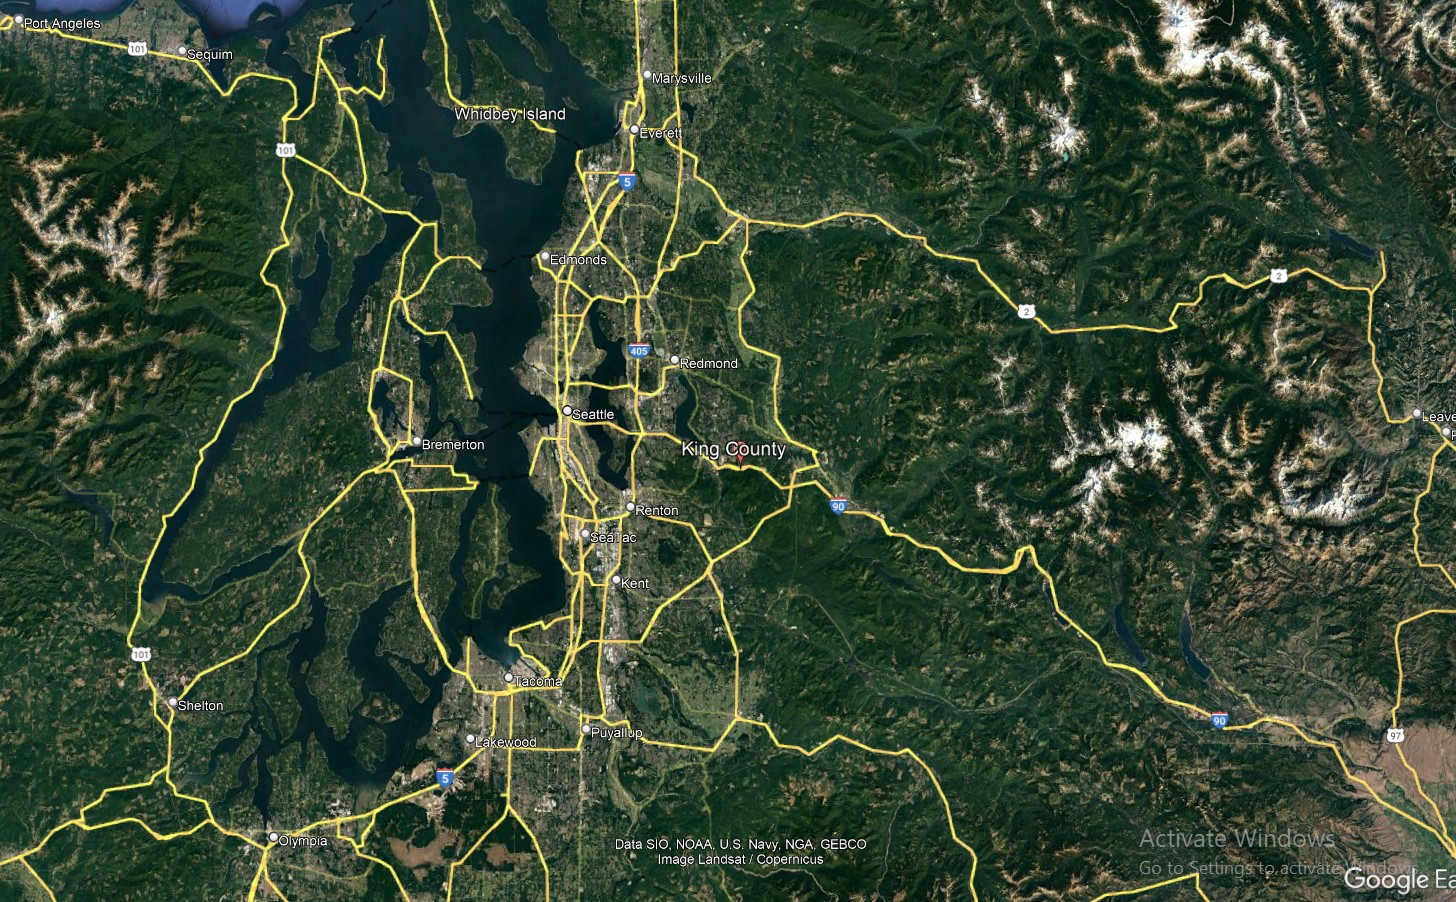

In [ ]:
fig = px.scatter(df_to_plot, x="long", y="lat", color='bedrooms', size = 'price', hover_name='city',
                 labels={"bedrooms": "Number of Bedrooms"})
fig.show()

In [ ]:
bedroom_bathroom_mean_df = df.groupby(['bedrooms','waterfront'])['price'].mean().reset_index()
pd.set_option('display.float_format', lambda x: f'{x:,.3f}')
bedroom_bathroom_mean_df

In [ ]:
df2 = df.copy()

In [ ]:
df2.loc[:, "price"] =df["price"].map('{:,.0f}'.format)

In [ ]:
df2.head()

In [ ]:
sns.displot(df['price'] , bins=30 , kde=True )
plt.show()

**correlation matrix**

In [ ]:
sns.heatmap(df.corr(), annot=False,cmap='RdYlGn')

In [ ]:
df3 = df['city'].value_counts().copy()

In [ ]:
fig, ax = plt.subplots(figsize=(6,10))
sns.barplot(x=df3.values, y=df3.index,ax=ax)
plt.xlabel('numerical amount of flats')
plt.title('Number of flats in location')
plt.show()

In [ ]:
df.columns

In [ ]:
df.sort_values('price',ascending=False)[['city']].head(20)

In [ ]:
df.isnull().sum()

In [ ]:
df.head()

In [ ]:
df.columns

**Calculating the skewness of the data and whether it is near to normal or not?**

In [ ]:
skewed = df.copy().drop(['city','id','date'],axis = 1)
print(f"Skewness of features:\n{skewed.skew()}")

**plotting boxplot to scrutinize outliers and acheive a gist of distribution in data**

In [ ]:
plt.figure(figsize = (16,8))

plt.subplot(2,1,1)
sns.boxplot(x = df['sqft_living'])

plt.subplot(2,1,2)
sns.boxplot(x = df['price'])
plt.show()

In [ ]:
#defining a function for determining the upper and lower threshold for 
def lower_upper(x):
    Q1 = np.percentile(x, 25)
    Q3 = np.percentile(x, 75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    return lower, upper

lower_area, upper_area = lower_upper(df['sqft_living'])
lower_price, upper_price = lower_upper(df['price'])

print(f"Lower limit for area: {lower_area:0.2f}")
print(f"Upper limit for area: {upper_area:0.2f}")
print(f"Lower limit for price: {lower_price:,}")
print(f"Upper limit for price: {upper_price:,}")

# **omitting outliers**

In [ ]:
area_outliers = np.where(df['sqft_living'] > upper_area)
price_outliers = np.where(df['price'] > upper_price)
# Return the unique, sorted array of values that are in either of the two input arrays.
total_outliers = np.union1d(area_outliers, price_outliers)

print(f"Number of area outliers: {len(df.iloc[area_outliers])}")
print(f"Number of price outliers: {len(df.iloc[price_outliers])}")
print(f"Number of outliers: {len(df.iloc[total_outliers])}")

In [ ]:
total_outliers

**Dropping the outliers**

In [ ]:
df = df.copy()
df.drop(total_outliers, inplace = True)
df.reset_index(drop = True, inplace = True)
print(f"Shape of new dataset: {df.shape}")

In [ ]:
skewed = df.copy().drop(['city','id','date'],axis = 1)
print(f"Skewness of features after drop outliers:\n{skewed.skew()}")

In [ ]:
plt.figure(figsize = (16,8))

plt.subplot(2,1,1)
sns.boxplot(x = df['sqft_living'])

plt.subplot(2,1,2)
sns.boxplot(x = df['price'])

**converting city column to some dummy columns or variables**

In [ ]:
df_final = df.dropna()

In [ ]:
df_final.isnull().sum()

In [ ]:
dummies = pd.get_dummies(df['city'],drop_first = True)
df_final = df.merge(dummies, left_index = True, right_index = True)
df_final.drop(columns = 'city', inplace = True)
df_final.head(3)

In [ ]:
df_final.columns

**Splitting data to train and test sets**

In [ ]:
X = df_final.drop(columns = ['price','id', 'date', 'zipcode'])
y = df_final['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
print(f"shape of x train: {X_train.shape}")
print(f"shape of y train: {y_train.shape}")
print(f"shape of x test: {X_test.shape}")
print(f"shape of y train: {y_test.shape}")

# defining a function to find the best hyperparameters for any model by means of GridSearchCV method

In [ ]:
def parameter_finder (model, parameters):
    
    start = time.time()
    
    grid = GridSearchCV(model, 
                        param_grid = parameters, 
                        refit = True, 
                        cv = KFold(shuffle = True, random_state = 1), 
                        n_jobs = -1)
    grid_fit = grid.fit(X_train, y_train)
    y_train_pred = grid_fit.predict(X_train)
    y_pred = grid_fit.predict(X_test)
    
    train_score =grid_fit.score(X_train, y_train)
    test_score = grid_fit.score(X_test, y_test)
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
    
    model_name = str(model).split('(')[0]
    
    end = time.time()
    
    print(f"The best parameters for {model_name} model is: {grid_fit.best_params_}")
    print("--" * 10)
    print(f"(R2 score) in the training set is {train_score:0.2%} for {model_name} model.")
    print(f"(R2 score) in the testing set is {test_score:0.2%} for {model_name} model.")
    print(f"RMSE is {RMSE:,} for {model_name} model.")
    print("--" * 10)
    print(f"Runtime of the program is: {end - start:0.2f}")
    
       
    return train_score, test_score, RMSE

# **Implementing the parameter finder function on different models**

**Linear regression**

In [ ]:
lr = LinearRegression(n_jobs = -1)

lr_train_score, lr_test_score, lr_RMSE = parameter_finder(lr, {})

# **Ridge, Lasso and ElasticNet Regression**
***Ridge and Lasso regression are some of the simple techniques to reduce model complexity and prevent over-fitting which may result from simple linear regression.
Ridge regression shrinks the coefficients and it helps to reduce the model complexity and multi-collinearity.
Lasso regression not only helps in reducing over-fitting but it can help us in feature selection.
Lasso regression can lead to feature selection whereas Ridge can only shrink coefficients close to zero.***(https://towardsdatascience.com/ridge-and-lasso-regression-a-complete-guide-with-python-scikit-learn-e20e34bcbf0b)
***By combining lasso and ridge regression we get Elastic-Net Regression. Elastic-Net Regression groups and shrinks the parameters associated with correlated variables and leaves them in the equation or removes them all at once.***(https://medium.com/@corymaklin/machine-learning-algorithms-part-11-ridge-regression-7d5861c2bc76)

In [ ]:
ridge = Ridge(random_state = 1) # Linear least squares with l2 regularization.
param_ridge = {'alpha': [0.001, 0.01, 0.1, 1, 10]}

ridge_train_score, ridge_test_score, ridge_RMSE = parameter_finder(ridge, param_ridge)

In [ ]:
lasso = Lasso(random_state = 1) # Linear Model trained with L1 prior as regularizer.
param_lasso = {'alpha': [0.001, 0.01, 0.1, 1, 10]}

lasso_train_score, lasso_test_score, lasso_RMSE = parameter_finder(lasso, param_lasso)

In [ ]:
eln = ElasticNet(random_state = 1) # Linear regression with combined L1 and L2 priors as regularizer.
param_eln = {'alpha': [0.001, 0.01, 0.1, 1, 10],
            'l1_ratio': [0.3, 0.4, 0.5, 0.6, 0.7]}

eln_train_score, eln_test_score, eln_RMSE = parameter_finder(eln, param_eln)

# **Random Forest and Decision Tree**

In [ ]:
dtr = DecisionTreeRegressor(random_state = 1)
param_dtr = {'min_samples_split': [2, 3, 4, 5],
            'min_samples_leaf': [1, 2, 3]}

dtr_train_score, dtr_test_score, dtr_RMSE = parameter_finder(dtr, param_dtr)

In [ ]:
rfr = RandomForestRegressor(random_state = 1, n_jobs = -1)
param_rfr = {'min_samples_split': [2, 3, 4, 5],
            'min_samples_leaf': [1, 2, 3]}

rfr_train_score, rfr_test_score, rfr_RMSE = parameter_finder(rfr, param_rfr)

# **K-nearest Neighbor**

In [ ]:
knr = KNeighborsRegressor(n_jobs = -1)
param_knr = {'n_neighbors': [5, 10, 15, 20],
            'weights': ['uniform', 'distance']}

knr_train_score, knr_test_score, knr_RMSE = parameter_finder(knr, param_knr)

# **XGBoost:**
**Random forest uses a technique called bagging to build full decision trees in parallel from random bootstrap samples of the data set. The final prediction is an average of all of the decision tree predictions.**

**The term “gradient boosting” comes from the idea of “boosting” or improving a single weak model by combining it with a number of other weak models in order to generate a collectively strong model. Gradient boosting is an extension of boosting where the process of additively generating weak models is formalized as a gradient descent algorithm over an objective function. Gradient boosting sets targeted outcomes for the next model in an effort to minimize errors. Targeted outcomes for each case are based on the gradient of the error (hence the name gradient boosting) with respect to the prediction.**

**GBDTs iteratively train an ensemble of shallow decision trees, with each iteration using the error residuals of the previous model to fit the next model. The final prediction is a weighted sum of all of the tree predictions. Random forest “bagging” minimizes the variance and overfitting, while GBDT “boosting” minimizes the bias and underfitting.**
https://www.nvidia.com/en-us/glossary/data-science/xgboost/#:~:text=What%20is%20XGBoost%3F,%2C%20classification%2C%20and%20ranking%20problems.

In [ ]:
xgboost = XGBRegressor(n_jobs = -1)
param_xgboost = {'n_estimators': [100,300],
             'learning_rate': [0.1,0.05],
             'subsample': [0.75],
             'colsample_bytree': [1],
             'max_depth': [3,4,5],
             'gamma': [0]}

xgboost_train_score, xgboost_test_score, xgboost_RMSE = parameter_finder(xgboost, param_xgboost)

# **Comparing models:**

In [ ]:
models_score = pd.DataFrame({'Training score': [lr_train_score, ridge_train_score, lasso_train_score, eln_train_score, dtr_train_score, rfr_train_score, knr_train_score,xgboost_train_score],
                             'Testing score': [lr_test_score, ridge_test_score, lasso_test_score, eln_test_score, dtr_test_score, rfr_test_score, knr_test_score,xgboost_test_score],
                             'RMSE': [lr_RMSE, ridge_RMSE, lasso_RMSE, eln_RMSE, dtr_RMSE, rfr_RMSE, knr_RMSE,xgboost_RMSE]},
                             index = ['LinearRegression', 'Ridge', 'Lasso','ElasticNet', 'DecisionTreeRegressor', 'RandomForestRegressor', 'KNeighborsRegressor','XGBoostRegressor'])

models_score

**Comparing the power of different algorithms by means of figures**

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))

sns.set(style='white')

ax.set_title("Camparison", fontsize = 20)

ax = sns.barplot(x = list(models_score.index), y = models_score['RMSE']/1000000000, alpha = 0.7, palette='Greens_r')

ax.set_ylabel("RMSE\n(billion tomans)", fontsize = 20)

sec_ax = ax.twinx()

sec_ax = sns.lineplot(x = list(models_score.index), y = models_score['Training score'], linewidth = 3, color = 'blue')
sec_ax = sns.scatterplot(x = list(models_score.index), y = models_score['Training score'], s = 200)

sec_ax = sns.lineplot(x = list(models_score.index), y = models_score['Testing score'], linewidth = 3, color = 'red')
sec_ax = sns.scatterplot(x = list(models_score.index), y = models_score['Testing score'], s = 200)

sec_ax.set_ylabel("R2 scores", fontsize = 20)

sec_ax.legend(labels = ['Training score', 'Testing score'], fontsize = 20)


sns.despine(offset = 10)

plt.show()
    